In [48]:
# Make the cells wider in the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

from importlib import reload
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import waveglow_model as model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
import train as train_utils
import DataLoader as DL

#############
False
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Epoch: 1/5
	Loss: 2.658
Epoch: 2/5
	Loss: 2.042
Epoch: 3/5
	Loss: 1.673
Epoch: 4/5
	Loss: 1.593
Epoch: 5/5
	Loss: 1.394


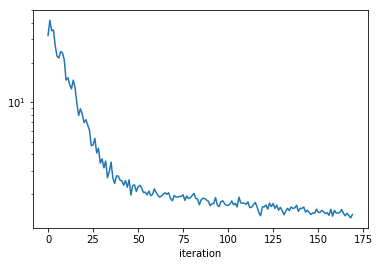

In [55]:
reload(train_utils)
reload(DL)
dataset = DL.DataLoader(rolling=True, train_f="./wind_power_data/wind_power_development.pickle")
config = {'n_flows': 6, 
          'n_group': 96, 
          'n_early_every': 99, 
          'n_early_size': 8, 
          'n_layers': 4, 
          'dilation_rate': 2, 
          'multiple': [0, 1], 
          'kernel_size': 3, 
          'learning_rate': 0.001, 
          'dataset': dataset}

params = [
    96, # n_context_channels
    6,  # n_flows
    96, # n_group
    99, # n_early_every
    8,  # n_early_size
    4,  # n_layers
    [1,1,1,1], # dilation_list
    96, # n_channels
    3,  # kernel_size
]
net = train_utils.training(
            dataset=dataset, 
            num_gpus=0, 
            output_directory='./train', 
            epochs=5, 
            learning_rate=1e-4, 
            batch_size=24, 
            checkpointing=False, 
            checkpoint_path="./checkpoints", 
            seed=2019, 
            params = params, 
            use_gpu=False, 
            gen_tests=False)


In [100]:
# Make some plots and stuff
num_samps = 50
orig_context, forecast = dataset.test_samples(num_contexts=num_samps)
torch_context = torch.FloatTensor(orig_context)
preds = net.generate(torch_context).numpy()


context = orig_context.squeeze()
print("context: ", context.shape)
print("forecast: ", forecast.shape)
print("preds: ", preds.shape)



context:  (50, 96)
forecast:  (50, 96)
preds:  (50, 96)


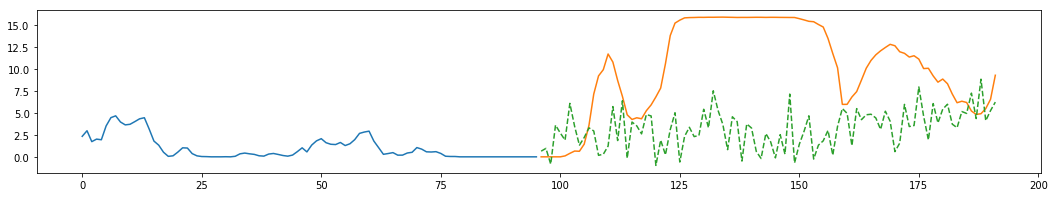

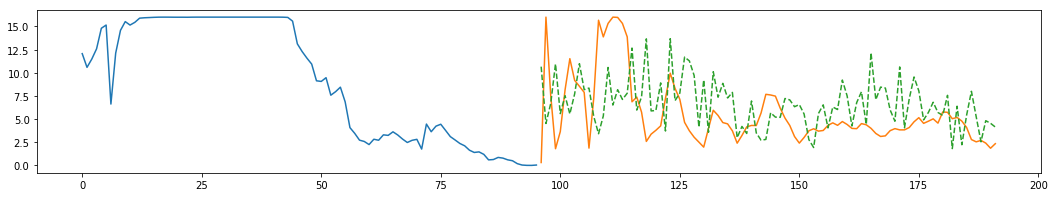

In [101]:
num_plot=2
for i in range(num_plot):
    ctx = context[i,:]
    fct = forecast[i,:]
    pred = preds[i,:]
    plt.figure(figsize=(18,3))
    plt.plot(range(len(ctx)), ctx, label="Context")
    plt.plot(range(len(ctx), len(ctx)+len(fct)), fct, label="True")
    plt.plot(range(len(ctx), len(ctx)+len(fct)), pred, '--', label="Forecast")
    
    

z:  (50, 96)


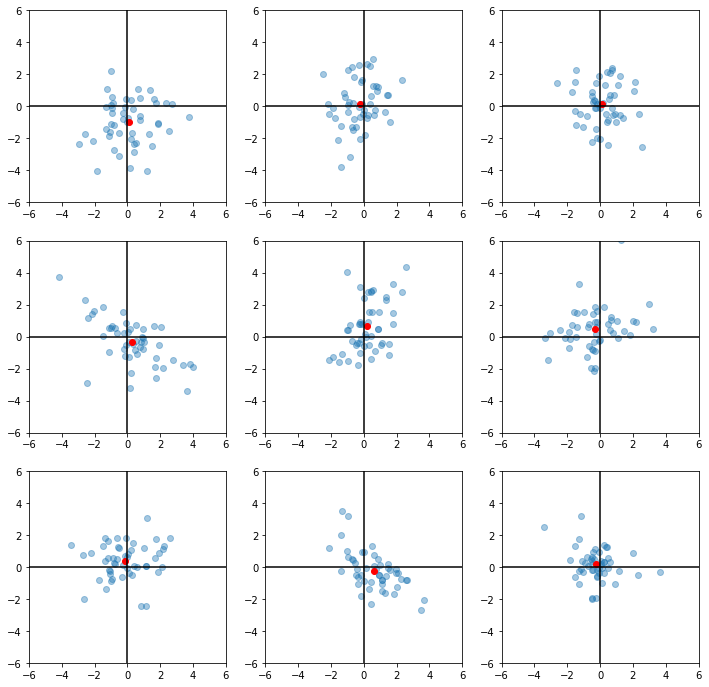

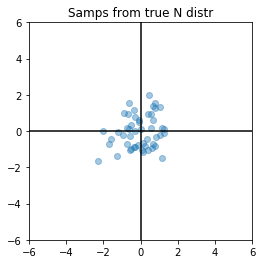

In [117]:
# Transform the test forecasts into the latent space, project them onto random planes
# see if they look like circularly distributed scatter plots (confirms the embedded
# points follow a spherical gaussian)
orig_z, log_s_list, log_det_w_list, early_assignment_shapes = net.forward(torch.FloatTensor(forecast), torch_context)
z = orig_z.detach().numpy().squeeze()
print("z: ", z.shape)

plot_rand_proj(z)

In [118]:
# Make sure if we transform these z's back into the original data space, they still match up roughly
torch_regen_forecast = net.generate(torch_context, latent_z=orig_z, early_assignment_shapes=early_assignment_shapes)
regen_forecast = torch_regen_forecast.numpy()
print("regen_forecast: ", regen_forecast.shape)
print("Max error in reconstruction: ", np.max(regen_forecast - forecast))

regen_forecast:  (50, 96)
Max error in reconstruction:  8.618164062390576e-05


In [92]:
def plot_rand_proj(data):
    ''' 
    Convenience function to plot 9 random projections of the data onto 2D planes
    Intention is to check if distr is truly spherical, since all projects should look like circles
    '''
    
    num_proj = 9
    ax_lim = 6 # to enforce all plots having same scaling
    data_dim = data.shape[1]
    
    if data_dim == 2:
        # No projection necessary, just plot it directly
        plt.figure(figsize=(4,4))
        plt.scatter(data[:,0], data[:,1], alpha=0.4)
        
        # Add axis lines and plot the empircal mean to see how well they match
        mu = np.mean(data, axis=1)
        plt.scatter(mu[0], mu[1], color="r")

        plt.axvline(0, color="black")
        plt.axhline(0, color="black")
        plt.xlim(-ax_lim, ax_lim)
        plt.ylim(-ax_lim, ax_lim)
        plt.title("Scatter plot of data")

    else:
        # Otherwise, project onto random 2D planes and look at those
        plt.figure(figsize=(12,12))
        for i in range(num_proj):
            # Generate a random orthogonal matrix using QR
            Q = np.linalg.qr(np.random.randn(data_dim,data_dim))[0]
            # Pick two random directions and project the data onto them
            P = Q[np.random.choice(range(data_dim), size=2, replace=False), :]
            proj = P @ data.T

            plt.subplot(3,3,i+1)
            plt.scatter(proj[0,:], proj[1,:], alpha=.4)

            # Add axis lines and plot the empircal mean to see how well they match
            mu = np.mean(proj, axis=1)
            plt.scatter(mu[0], mu[1], color="r")

            plt.axvline(0, color="black")
            plt.axhline(0, color="black")
            plt.xlim(-ax_lim, ax_lim)
            plt.ylim(-ax_lim, ax_lim)

    # For comparison, also plot an example scatter plot from a true normal distribution
    samps = np.random.randn(2, data.shape[0])
    plt.figure(figsize=(4,4))
    plt.scatter(samps[0,:], samps[1,:], alpha=0.4)
    plt.axvline(0, color="black")
    plt.axhline(0, color="black")
    plt.xlim(-ax_lim, ax_lim)
    plt.ylim(-ax_lim, ax_lim)
    plt.title("Samps from true N distr");

In [20]:
# Import the data
trainset = pd.read_pickle("wind_power_data/wind_power_train.pickle").values
testset = pd.read_pickle("wind_power_data/wind_power_test.pickle").values

In [31]:
samp = trainset[:96]
samp = np.reshape(samp, (1,96))




# samp = np.vstack([samp, samp])
print(samp.shape)
samp_torch = torch.autograd.Variable(torch.FloatTensor(samp))

context = samp[:, :, None]
# context = np.vstack([context, context])
print(context.shape)
context_torch = torch.autograd.Variable(torch.FloatTensor(context))

samp_torch.unfold(1, 24, 24).shape

(1, 96)
(1, 96, 1)


torch.Size([1, 4, 24])

In [32]:
print(context.shape)
print(samp_torch.shape)

(1, 96, 1)
torch.Size([1, 96])


In [33]:
z, log_s_list, log_det_w_list, early_out_shapes = net(samp_torch, context_torch)

In [34]:
z.shape

torch.Size([1, 96, 1])

In [44]:
# forecast = net.generate(context_torch, latent_z=z, early_assignment_shapes=early_out_shapes)
forecast = net.generate(context_torch)


In [45]:
forecast.shape

torch.Size([1, 96])

In [52]:
forecast.numpy().squeeze()

array([ 0.29736346,  3.0211618 ,  4.502302  ,  6.8203945 ,  4.3782635 ,
        4.063792  ,  1.402211  , -0.52565944,  6.699255  ,  4.178144  ,
        8.551556  ,  8.598002  ,  3.9250352 ,  0.59907544,  9.735182  ,
        3.870706  ,  2.8701563 ,  3.176619  ,  0.8782251 ,  5.5330887 ,
        1.124871  ,  2.0158653 ,  4.1762595 , -2.4269197 ,  3.5499594 ,
        5.299763  ,  5.7467065 ,  6.18073   ,  4.819233  , -0.58786166,
        3.0935209 ,  0.10110326, -4.806804  ,  6.1686563 ,  2.512915  ,
        5.35138   ,  9.632306  ,  1.2713368 ,  1.2485621 ,  4.3565803 ,
        0.01167572,  3.6538677 ,  3.5892835 ,  3.2429314 ,  5.5996385 ,
        6.3396006 ,  5.599048  ,  3.2350936 ,  7.316822  , -0.4587848 ,
        5.6169286 ,  3.7910159 ,  7.840236  ,  3.084224  ,  5.9104185 ,
        6.970928  ,  5.2813425 ,  4.4197307 ,  8.188396  ,  5.0621166 ,
        0.53503436,  1.3936906 ,  3.6713588 ,  2.0454304 ,  1.2952195 ,
        2.4212637 ,  9.3242855 , -2.4226325 ,  3.583569  ,  5.52

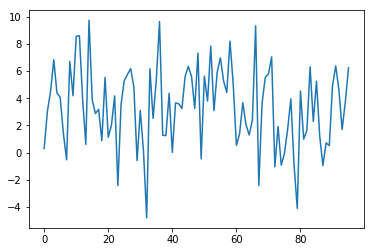

In [53]:
plt.plot(forecast.numpy().squeeze())

In [37]:
forecast.numpy().shape

(1, 96)

In [38]:
samp_torch

tensor([[ 0.0760,  0.0600,  0.0600,  0.0640,  0.0620,  0.0530,  0.0670,  0.1120,
          0.3530,  0.5690,  0.7650,  0.8170,  0.7950,  1.0850,  1.1670,  1.4590,
          1.5330,  1.4970,  1.6760,  1.8240,  2.0530,  2.7030,  3.1530,  4.1340,
          4.6270,  5.7560,  6.8790,  8.1850,  8.8390,  9.0900, 11.5000, 13.3160,
         14.6710, 15.1870, 15.5030, 15.4410, 15.5680, 15.8660, 15.9200, 15.9150,
         15.9010, 15.8920, 15.9310, 15.9300, 15.9590, 15.9880, 15.9780, 15.9920,
         15.9940, 15.9940, 15.9950, 15.9920, 15.9940, 15.9970, 15.9930, 15.9940,
         15.9900, 15.9530, 15.9420, 15.4970, 13.5840, 10.8160,  8.6550,  4.9210,
          2.5130,  1.7040,  1.6020,  1.5680,  1.2830,  1.0180,  0.9310,  1.4980,
          1.5950,  1.4840,  1.4300,  1.4200,  1.0690,  0.8060,  0.7370,  0.5880,
          0.3710,  0.1410,  0.0590,  0.0880,  0.2560,  0.3530,  0.2980,  0.3040,
          0.4070,  0.5120,  0.4870,  0.6190,  0.6440,  0.8720,  1.4810,  1.6690]])

In [43]:
forecast - samp_torch

tensor([[ 1.8105e-05, -2.8569e-05, -1.4257e-05,  8.9556e-06, -3.6005e-05,
          2.6412e-06,  9.5367e-07,  1.1764e-05,  2.3574e-05, -2.2650e-06,
          1.1265e-05,  1.2100e-05, -8.1062e-06,  2.5153e-05, -1.1802e-05,
         -1.3113e-05, -4.5061e-05,  3.8028e-05,  1.2040e-05, -1.5378e-05,
         -1.9789e-05,  2.3842e-05,  1.3351e-05, -6.6757e-06, -3.0994e-05,
          1.0967e-05, -5.2452e-06,  1.3351e-05, -9.5367e-07, -3.8147e-06,
          1.8120e-05,  8.5831e-06,  2.3842e-05,  1.7166e-05,  4.7684e-06,
          5.0545e-05,  4.1962e-05,  2.0027e-05,  4.1008e-05,  2.5749e-05,
          9.5367e-07, -2.2888e-05,  3.8147e-06, -1.0490e-05, -3.8147e-06,
          1.3351e-05, -8.5831e-06, -1.5259e-05, -1.6212e-05, -2.8610e-06,
          2.9564e-05,  2.8610e-06,  2.8610e-06,  2.3842e-05, -2.0027e-05,
         -6.6757e-06,  4.7684e-06,  1.2398e-05, -1.8120e-05, -1.1444e-05,
         -2.8610e-05, -2.2888e-05,  1.6212e-05, -2.3842e-06, -2.6464e-05,
         -1.6689e-06, -2.0862e-05, -7.

In [41]:
torch.max(forecast - samp_torch)

tensor(5.0545e-05)

In [42]:
torch.allclose(forecast, samp_torch, atol=6e-5)

True